In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import butter, filtfilt, hilbert
from scipy.fft import rfft, rfftfreq
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.fft import fft, fftfreq
from scipy.signal import welch, stft
import time
import seaborn as sns

# Analisis de la señal

In [ ]:
def plot_bearing_signals(csv_path, defect_name, fs=51200):
    font = "Cambria"

    columns_colors = {
        "tachometer": "tab:blue",
        "acc_under_axial": "tab:orange",
        "acc_under_radial": "tab:green",
        "acc_under_tangential": "tab:red",
        "acc_over_axial": "tab:blue",
        "acc_over_radial": "tab:orange",
        "acc_over_tangential": "tab:green",
        "microphone": "tab:red"
    }

    columns = list(columns_colors.keys())

    data = pd.read_csv(csv_path, header=None)
    data.columns = columns

    base_output_dir = "./analysis/raw_signals"
    os.makedirs(base_output_dir, exist_ok=True)

    for sig in columns:
        signal = data[sig].values
        color = columns_colors[sig]
        N = len(signal)
        t = np.arange(N) / fs

        fft_vals = fft(signal)
        fft_freqs = fftfreq(N, 1 / fs)
        pos_mask = fft_freqs >= 0

        sensor_dir = os.path.join(base_output_dir, sig)
        os.makedirs(sensor_dir, exist_ok=True)
        file_path = os.path.join(sensor_dir, f"{defect_name}.png")

        fig, axs = plt.subplots(1, 2, figsize=(18, 5))
        fig.suptitle(
            f"{sig} - {defect_name}",
            fontsize=22,
            fontfamily=font
        )

        # Tiempo
        axs[0].plot(t, signal, color=color)
        axs[0].set_title("Dominio temporal", fontsize=18, fontfamily=font)
        axs[0].set_xlabel("Tiempo (s)", fontsize=16, fontfamily=font)
        axs[0].set_ylabel("Amplitud", fontsize=16, fontfamily=font)
        axs[0].set_ylim(-5, 2)
        axs[0].set_xlim(0, max(t))
        axs[0].grid(True)

        # FFT
        axs[1].plot(
            fft_freqs[pos_mask],
            np.abs(fft_vals[pos_mask]) / N,
            color=color
        )
        axs[1].set_title("FFT", fontsize=18, fontfamily=font)
        axs[1].set_xlabel("Frecuencia (Hz)", fontsize=16, fontfamily=font)
        axs[1].set_ylabel("Magnitud", fontsize=16, fontfamily=font)
        axs[1].set_ylim(0, 0.65)
        axs[1].set_xlim(-100, max(fft_freqs))
        axs[1].grid(True)

        for ax in axs:
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontfamily(font)
                label.set_fontsize(15)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(file_path, dpi=300)
        plt.close(fig)

    print(f"Gráficos generados para {defect_name}")

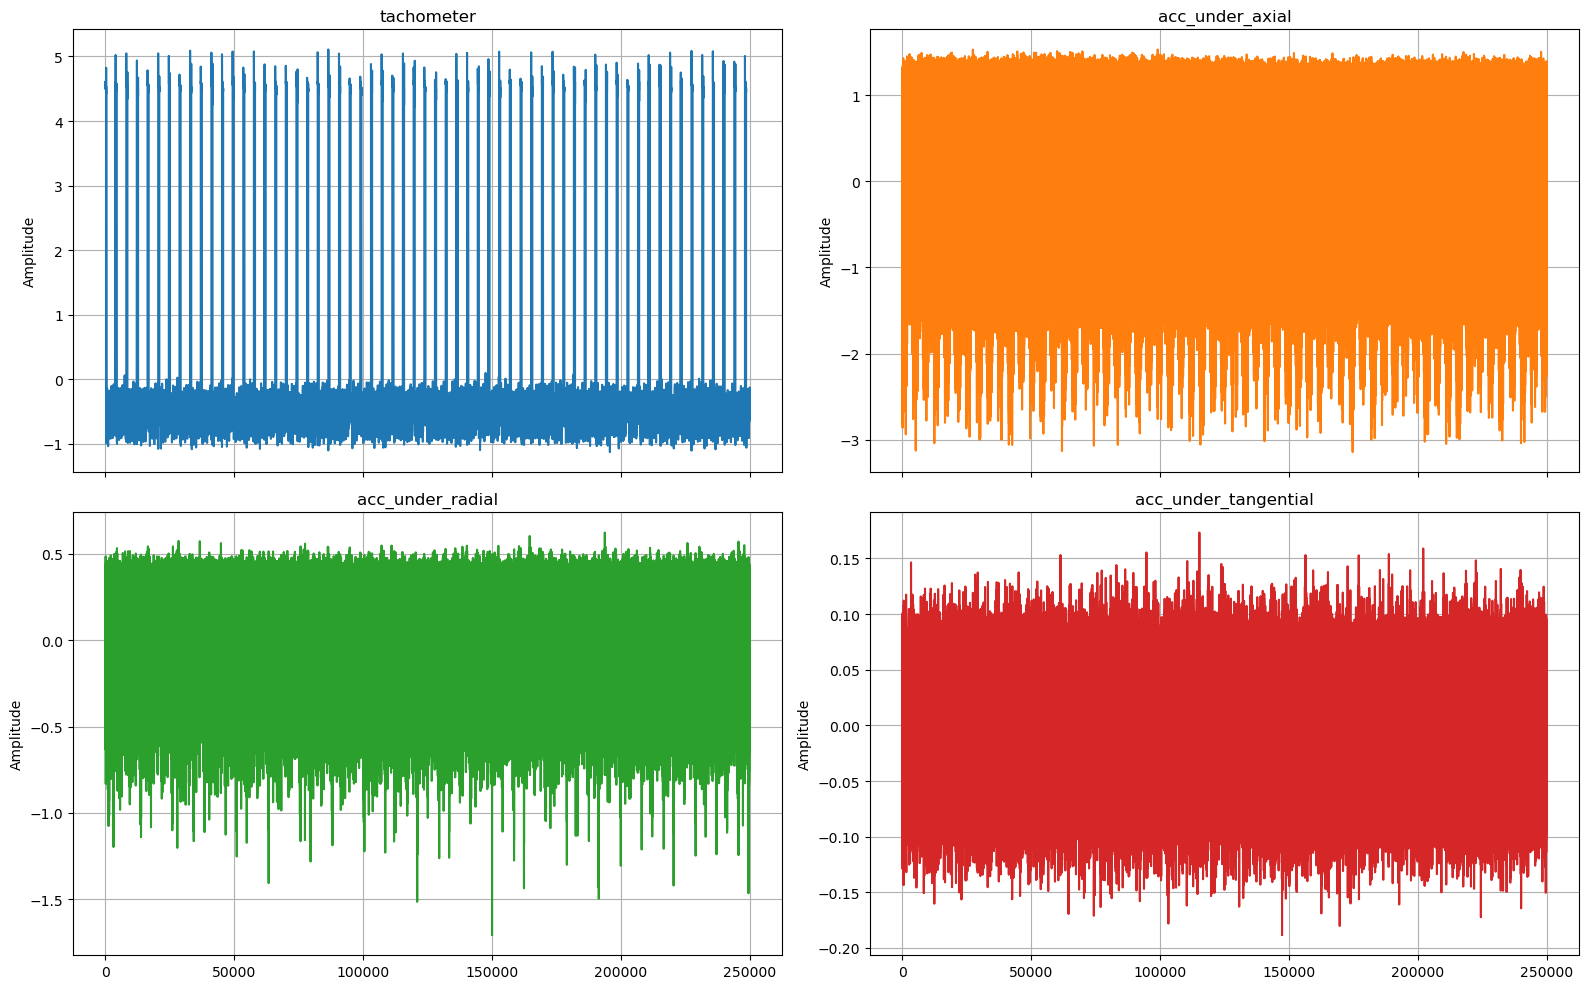

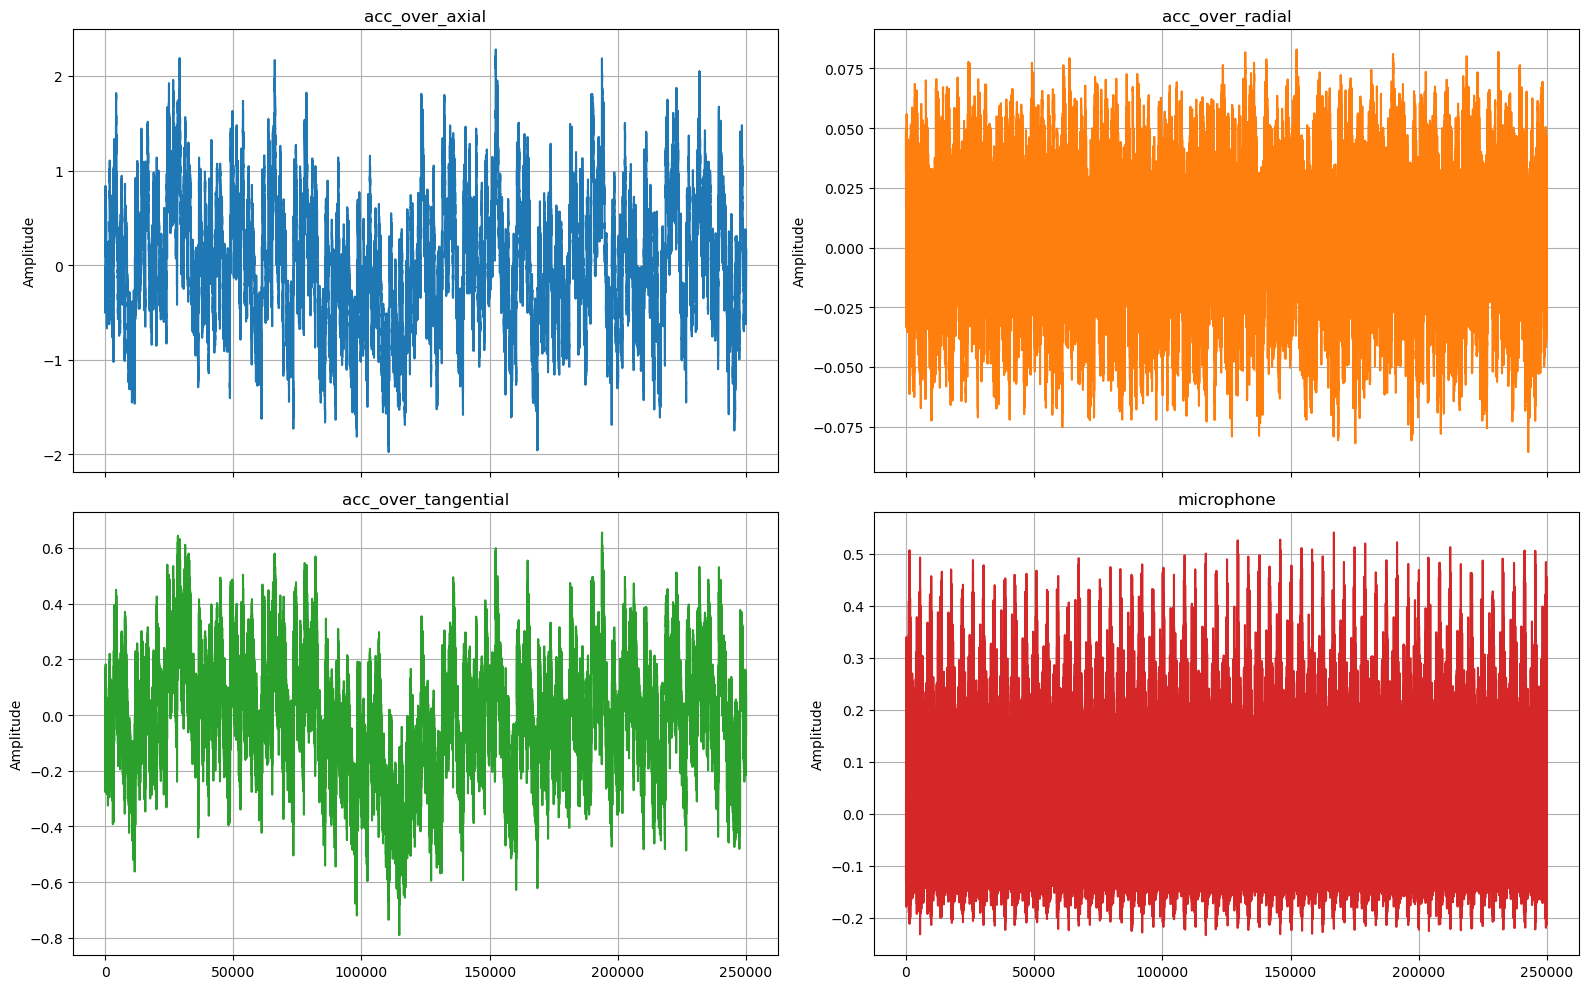

In [8]:
plot_bearing_signals("bearing_fault_detection/normal/12.288.csv", "normal")
plot_bearing_signals("bearing_fault_detection_reduced/overhang/ball_fault/0g/12.9024.csv","overhang_ball_fault")
plot_bearing_signals("bearing_fault_detection_reduced/overhang/cage_fault/0g/13.1072.csv", "overhang_cage_fault")
plot_bearing_signals("bearing_fault_detection_reduced/overhang/outer_race/0g/13.1072.csv", "overhang_outer_race")
plot_bearing_signals("bearing_fault_detection_reduced/underhang/ball_fault/0g/13.1072.csv", "underhang")
plot_bearing_signals("bearing_fault_detection_reduced/imbalance/6g/13.9264.csv", "imbalance")
plot_bearing_signals("bearing_fault_detection_reduced/horizontal-misalignment/0.5mm/12.288.csv", "horizontal-misalignment")
plot_bearing_signals("bearing_fault_detection_reduced/vertical-misalignment/0.51mm/12.4928.csv", "vertical-misalignment")

In [ ]:
def plot_filtered_signals(csv_path, defect_name, fs=51200):
    font = "Cambria"

    columns_colors = {
        "tachometer": "tab:blue",
        "acc_under_axial": "tab:orange",
        "acc_under_radial": "tab:green",
        "acc_under_tangential": "tab:red",
        "acc_over_axial": "tab:blue",
        "acc_over_radial": "tab:orange",
        "acc_over_tangential": "tab:green",
        "microphone": "tab:red"
    }

    columns = list(columns_colors.keys())

    def butter_lowpass(cutoff, fs, order=4):
        b, a = butter(order, cutoff, btype='low', fs=fs)
        return b, a

    def butter_highpass(cutoff, fs, order=4):
        b, a = butter(order, cutoff, btype='high', fs=fs)
        return b, a

    def apply_lowpass(signal, fs, cutoff, order=4):
        b, a = butter_lowpass(cutoff, fs, order)
        return filtfilt(b, a, signal)

    def apply_highpass(signal, fs, cutoff, order=4):
        b, a = butter_highpass(cutoff, fs, order)
        return filtfilt(b, a, signal)

    df = pd.read_csv(csv_path, header=None)
    df.columns = columns

    base_output_dir = "./analysis/filtered_signals"
    os.makedirs(base_output_dir, exist_ok=True)

    for sig in columns:
        signal = df[sig].values
        color = columns_colors[sig]
        N = len(signal)
        t = np.arange(N) / fs

        signal_low = apply_lowpass(signal, fs, 500)
        signal_high = apply_highpass(signal, fs, 20000)

        sensor_dir = os.path.join(base_output_dir, sig)
        os.makedirs(sensor_dir, exist_ok=True)
        file_path = os.path.join(sensor_dir, f"{defect_name}.png")

        fig, axs = plt.subplots(1, 2, figsize=(18, 5))
        fig.suptitle(f"{sig} - {defect_name}", fontsize=22, fontfamily=font)

        axs[0].plot(t, signal_low, color=color)
        axs[0].set_title("Lowpass", fontsize=18, fontfamily=font)
        axs[0].set_xlabel("Tiempo (s)", fontsize=16, fontfamily=font)
        axs[0].set_ylabel("Amplitud", fontsize=16, fontfamily=font)
        axs[0].set_xlim(0, max(t))
        axs[0].set_ylim(-3, 3)
        axs[0].grid(True)

        axs[1].plot(t, signal_high, color=color)
        axs[1].set_title("Highpass", fontsize=18, fontfamily=font)
        axs[1].set_xlabel("Tiempo (s)", fontsize=16, fontfamily=font)
        axs[1].set_ylabel("Amplitud", fontsize=16, fontfamily=font)
        axs[1].set_xlim(0, max(t))
        axs[1].set_ylim(-3, 3)
        axs[1].grid(True)

        for ax in axs:
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontfamily(font)
                label.set_fontsize(14)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(file_path, dpi=300)
        plt.close(fig)

    print(f"Gráficos filtrados en el dominio temporal generados para '{defect_name}'")

In [ ]:
plot_bearing_signals("bearing_fault_detection/normal/12.288.csv", "normal")
plot_bearing_signals("bearing_fault_detection_reduced/overhang/ball_fault/0g/12.9024.csv", "overhang_ball_fault")
plot_bearing_signals("bearing_fault_detection_reduced/overhang/cage_fault/0g/13.1072.csv", "overhang_cage_fault")
plot_bearing_signals("bearing_fault_detection_reduced/overhang/outer_race/0g/13.1072.csv", "overhang_outer_race")
plot_bearing_signals("bearing_fault_detection_reduced/underhang/ball_fault/0g/13.1072.csv", "underhang")
plot_bearing_signals("bearing_fault_detection_reduced/imbalance/6g/13.9264.csv", "imbalance")
plot_bearing_signals("bearing_fault_detection_reduced/horizontal-misalignment/0.5mm/12.288.csv",
                     "horizontal-misalignment")
plot_bearing_signals("bearing_fault_detection_reduced/vertical-misalignment/0.51mm/12.4928.csv",
                     "vertical-misalignment")

# Extraccion de caracteristicas

In [36]:
def apply_lowpass(signal, fs, cutoff, order=4):
    b, a = butter(order, cutoff, btype='low', fs=fs)
    return filtfilt(b, a, signal)

def apply_highpass(signal, fs, cutoff, order=4):
    b, a = butter(order, cutoff, btype='high', fs=fs)
    return filtfilt(b, a, signal)

def time_features(x):
    return {
        "rms": np.sqrt(np.mean(x**2)),
        "peak_to_peak": np.ptp(x),
        "kurtosis": kurtosis(x, fisher=False)
    }

def shape_features(x):
    rms = np.sqrt(np.mean(x**2))
    return {"crest_factor": np.max(np.abs(x)) / rms if rms != 0 else 0}

def energy_features(x):
    return {"signal_energy": np.sum(x**2)}

def spectral_features(x, fs):
    N = len(x)
    xf = np.abs(rfft(x))
    freqs = rfftfreq(N, 1/fs)
    power = xf**2
    power_sum = np.sum(power) + 1e-12
    return {
        "dominant_freq": freqs[np.argmax(power)],
        "spectral_centroid": np.sum(freqs * power) / power_sum
    }

def envelope_features(x):
    env = np.abs(hilbert(x))
    return {
        "envelope_rms": np.sqrt(np.mean(env**2)),
        "envelope_kurtosis": kurtosis(env, fisher=False)
    }

def dominant_frequency(x, fs):
    x = x - np.mean(x)
    N = len(x)
    X = np.abs(rfft(x))
    freqs = rfftfreq(N, 1/fs)

    X[0] = 0

    return freqs[np.argmax(X)]

def extract_features(csv_path, label, label2, fs, lf_cutoff=500, hf_cutoff=20000, n_periods=None):
    """
    Calcula features para baja frecuencia (<lf_cutoff) y alta frecuencia (>hf_cutoff)
    para cada sensor
    """
    sensors = ["tachometer", "acc_under_axial", "acc_under_radial", "acc_under_tangential",
               "acc_over_axial", "acc_over_radial", "acc_over_tangential", "microphone"]

    df = pd.read_csv(csv_path, header=None)
    df.columns = sensors

    row = {"fault": label, "fault2": label2, "file": os.path.basename(csv_path)}

    tach = df["tachometer"].values
    f_dom = dominant_frequency(tach, fs)

    if f_dom <= 0:
        return None
    samples_per_period = int(fs / f_dom)
    if n_periods is not None:
        n_samples = samples_per_period * n_periods
        n_samples = min(n_samples, len(tach))
    else:
        n_samples = len(tach)

    for sig in sensors[1:]:
        x = df[sig].values
        x = x[-n_samples:]

        x_lf = apply_lowpass(x, fs, lf_cutoff)
        features_lf = {
            **time_features(x_lf),
            **shape_features(x_lf),
            **energy_features(x_lf),
            **spectral_features(x_lf, fs),
            **envelope_features(x_lf)
        }

        for k, v in features_lf.items():
            row[f"{sig}_lf_{k}"] = v

        x_hf = apply_highpass(x, fs, hf_cutoff)
        features_hf = {
            **time_features(x_hf),
            **shape_features(x_hf),
            **energy_features(x_hf),
            **spectral_features(x_hf, fs),
            **envelope_features(x_hf)
        }

        for k, v in features_hf.items():
            row[f"{sig}_hf_{k}"] = v

    return row

In [ ]:
def generate_feature_dataset(
    base_dir,
    output_file,
    fs=51200,
    n_periods=None
):
    """
    Recorre el directorio base, extrae features de cada CSV y guarda el dataset final.

    Parameters
    ----------
    base_dir : str
        Directorio raíz del dataset.
    output_file : str
        Ruta del CSV de salida.
    fs : float
        Frecuencia de muestreo.
    n_periods : int or None
        Número de periodos a utilizar. Si es None, se usa toda la señal.
    """

    rows = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".csv"):
                csv_path = os.path.join(root, file)

                rel_path = os.path.relpath(csv_path, base_dir)
                parts = rel_path.split(os.sep)

                label = parts[0]

                if label in ["overhang", "underhang"] and len(parts) > 2:
                    label2 = parts[1]
                else:
                    label2 = None

                rows.append((csv_path, label, label2))

    feature_rows = []

    for csv_path, label, label2 in tqdm(rows, desc="Extrayendo features"):
        row = extract_features(
            csv_path,
            label,
            label2,
            fs,
            n_periods=n_periods
        )
        if row is not None:
            feature_rows.append(row)

    df_features = pd.DataFrame(feature_rows)
    df_features.to_csv(output_file, index=False)

    return df_features

In [28]:
BASE_DIR = "bearing_fault_detection"
OUTPUT_PATH = "features_bearing_fault_detection2.csv"

df1 = generate_feature_dataset(BASE_DIR, OUTPUT_PATH)
OUTPUT_PATH = "features_bearing_fault_detection_short_1t.csv"

df2 = generate_feature_dataset(BASE_DIR, OUTPUT_PATH, n_periods=1)
OUTPUT_PATH = "features_bearing_fault_detection_short_2t.csv"

df3 = generate_feature_dataset(BASE_DIR, OUTPUT_PATH, n_periods=2)

OUTPUT_PATH = "features_bearing_fault_detection_short_5t.csv"

df4 = generate_feature_dataset(BASE_DIR, OUTPUT_PATH, n_periods=5)

OUTPUT_PATH = "features_bearing_fault_detection_short_10t.csv"

df5 = generate_feature_dataset(BASE_DIR, OUTPUT_PATH, n_periods=10)

# Seleccion de ventana

In [20]:
df1 = pd.read_csv("features_bearing_fault_detection2.csv")
df2 = pd.read_csv("features_bearing_fault_detection_short_10t.csv")
df3 = pd.read_csv("features_bearing_fault_detection_short_5t.csv")
df4 = pd.read_csv("features_bearing_fault_detection_short_2t.csv")
df5 = pd.read_csv("features_bearing_fault_detection_short_1t.csv")
label_map = {
    "normal": 0,
    "overhang": 1,
    "underhang": 2,
    "imbalance": 3,
    "horizontal-misalignment": 4,
    "vertical-misalignment": 5
}

df1['label'] = df1['fault'].map(label_map)
df2['label'] = df2['fault'].map(label_map)
df3['label'] = df3['fault'].map(label_map)
df4['label'] = df4['fault'].map(label_map)
df5['label'] = df5['fault'].map(label_map)


In [21]:
X1 = df1.drop(columns=['label', 'fault', 'file', 'fault2'])
y1 = df1['label']
X2= df2.drop(columns=['label', 'fault', 'file', 'fault2'])
y2 = df2['label']
X3 = df3.drop(columns=['label', 'fault', 'file', 'fault2'])
y3 = df3['label']
X4= df4.drop(columns=['label', 'fault', 'file', 'fault2'])
y4 = df4['label']
X5 = df5.drop(columns=['label', 'fault', 'file', 'fault2'])
y5 = df5['label']

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, random_state=42, stratify=y3
)
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, test_size=0.2, random_state=42, stratify=y4
)
X5_train, X5_test, y5_train, y5_test = train_test_split(
    X5, y5, test_size=0.2, random_state=42, stratify=y5
)

print("Train1 size:", X1_train.shape)
print("Test1 size:", X1_test.shape)

Train1 size: (1560, 126)
Test1 size: (391, 126)


In [22]:
clf = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

clf.fit(X1_train, y1_train)

y1_pred1 = clf.predict(X1_test)
y2_pred1 = clf.predict(X2_test)
y3_pred1 = clf.predict(X3_test)
y4_pred1 = clf.predict(X4_test)
y5_pred1 = clf.predict(X5_test)

In [23]:
print("Confusion Matrix:\n", confusion_matrix(y1_test, y1_pred1))
print("\nClassification Report:\n", classification_report(y1_test, y1_pred1))
print("Confusion Matrix:\n", confusion_matrix(y2_test, y2_pred1))
print("\nClassification Report:\n", classification_report(y2_test, y2_pred1))
print("Confusion Matrix:\n", confusion_matrix(y3_test, y3_pred1))
print("\nClassification Report:\n", classification_report(y3_test, y3_pred1))
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred1))
print("\nClassification Report:\n", classification_report(y4_test, y4_pred1))
print("Confusion Matrix:\n", confusion_matrix(y5_test, y5_pred1))
print("\nClassification Report:\n", classification_report(y5_test, y5_pred1))

Confusion Matrix:
 [[  9   0   0   0   0   1]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   0  67   0   0]
 [  0   0   0   0  39   0]
 [  0   0   1   0   0  59]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00       103
           2       0.99      1.00      1.00       112
           3       1.00      1.00      1.00        67
           4       1.00      1.00      1.00        39
           5       0.98      0.98      0.98        60

    accuracy                           0.99       391
   macro avg       1.00      0.98      0.99       391
weighted avg       0.99      0.99      0.99       391

Confusion Matrix:
 [[  7   0   2   1   0   0]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   1  66   0   0]
 [  0   1   0   0  38   0]
 [  0   1   0   2   0  57]]

Classification Report:
               precision    recall  f1-score

In [26]:
clf2 = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

clf2.fit(X2_train, y2_train)

y2_pred2 = clf2.predict(X2_test)
y3_pred2 = clf2.predict(X3_test)
y4_pred2 = clf2.predict(X4_test)
y5_pred2 = clf2.predict(X5_test)

In [27]:
print("Confusion Matrix:\n", confusion_matrix(y2_test, y2_pred2))
print("\nClassification Report:\n", classification_report(y2_test, y2_pred2))
print("Confusion Matrix:\n", confusion_matrix(y3_test, y3_pred2))
print("\nClassification Report:\n", classification_report(y3_test, y3_pred2))
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred2))
print("\nClassification Report:\n", classification_report(y4_test, y4_pred2))
print("Confusion Matrix:\n", confusion_matrix(y5_test, y5_pred2))
print("\nClassification Report:\n", classification_report(y5_test, y5_pred2))

Confusion Matrix:
 [[  8   0   0   0   0   2]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   1  66   0   0]
 [  0   0   0   0  39   0]
 [  0   1   0   0   0  59]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.99      1.00      1.00       103
           2       0.99      1.00      1.00       112
           3       1.00      0.99      0.99        67
           4       1.00      1.00      1.00        39
           5       0.97      0.98      0.98        60

    accuracy                           0.99       391
   macro avg       0.99      0.96      0.97       391
weighted avg       0.99      0.99      0.99       391

Confusion Matrix:
 [[ 10   0   0   0   0   0]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   2  65   0   0]
 [  0   0   0   0  39   0]
 [  0   1   0   1   0  58]]

Classification Report:
               precision    recall  f1-score

In [28]:
clf3 = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

clf3.fit(X3_train, y3_train)

y3_pred3 = clf3.predict(X3_test)
y4_pred3 = clf3.predict(X4_test)
y5_pred3 = clf3.predict(X5_test)

In [29]:
print("Confusion Matrix:\n", confusion_matrix(y3_test, y3_pred3))
print("\nClassification Report:\n", classification_report(y3_test, y3_pred3))
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred3))
print("\nClassification Report:\n", classification_report(y4_test, y4_pred3))
print("Confusion Matrix:\n", confusion_matrix(y5_test, y5_pred3))
print("\nClassification Report:\n", classification_report(y5_test, y5_pred3))

Confusion Matrix:
 [[  7   0   0   0   0   3]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   2  65   0   0]
 [  0   0   0   0  39   0]
 [  0   1   0   0   0  59]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.99      1.00      1.00       103
           2       0.98      1.00      0.99       112
           3       1.00      0.97      0.98        67
           4       1.00      1.00      1.00        39
           5       0.95      0.98      0.97        60

    accuracy                           0.98       391
   macro avg       0.99      0.94      0.96       391
weighted avg       0.99      0.98      0.98       391

Confusion Matrix:
 [[  5   0   2   0   1   2]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   2  63   1   1]
 [  0   2   2   0  35   0]
 [  0   2   1   1   1  55]]

Classification Report:
               precision    recall  f1-score

In [30]:
clf4 = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

clf4.fit(X4_train, y4_train)

y4_pred4 = clf4.predict(X4_test)
y5_pred4 = clf4.predict(X5_test)

In [31]:
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred4))
print("\nClassification Report:\n", classification_report(y4_test, y4_pred4))
print("Confusion Matrix:\n", confusion_matrix(y5_test, y5_pred4))
print("\nClassification Report:\n", classification_report(y5_test, y5_pred4))

Confusion Matrix:
 [[  6   0   0   0   1   3]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   2  62   1   2]
 [  0   0   0   0  37   2]
 [  0   0   1   1   1  57]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       1.00      1.00      1.00       103
           2       0.97      1.00      0.99       112
           3       0.98      0.93      0.95        67
           4       0.93      0.95      0.94        39
           5       0.89      0.95      0.92        60

    accuracy                           0.96       391
   macro avg       0.96      0.90      0.92       391
weighted avg       0.97      0.96      0.96       391

Confusion Matrix:
 [[  6   0   0   0   1   3]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   2  62   1   2]
 [  0   0   0   0  37   2]
 [  0   0   1   1   1  57]]

Classification Report:
               precision    recall  f1-score

In [32]:
clf5 = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

clf5.fit(X5_train, y5_train)

y5_pred5 = clf5.predict(X5_test)

In [33]:
print("Confusion Matrix:\n", confusion_matrix(y5_test, y5_pred5))
print("\nClassification Report:\n", classification_report(y5_test, y5_pred5))

Confusion Matrix:
 [[  6   0   0   0   1   3]
 [  0 103   0   0   0   0]
 [  0   0 112   0   0   0]
 [  0   0   2  62   1   2]
 [  0   0   0   0  37   2]
 [  0   0   1   1   1  57]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       1.00      1.00      1.00       103
           2       0.97      1.00      0.99       112
           3       0.98      0.93      0.95        67
           4       0.93      0.95      0.94        39
           5       0.89      0.95      0.92        60

    accuracy                           0.96       391
   macro avg       0.96      0.90      0.92       391
weighted avg       0.97      0.96      0.96       391



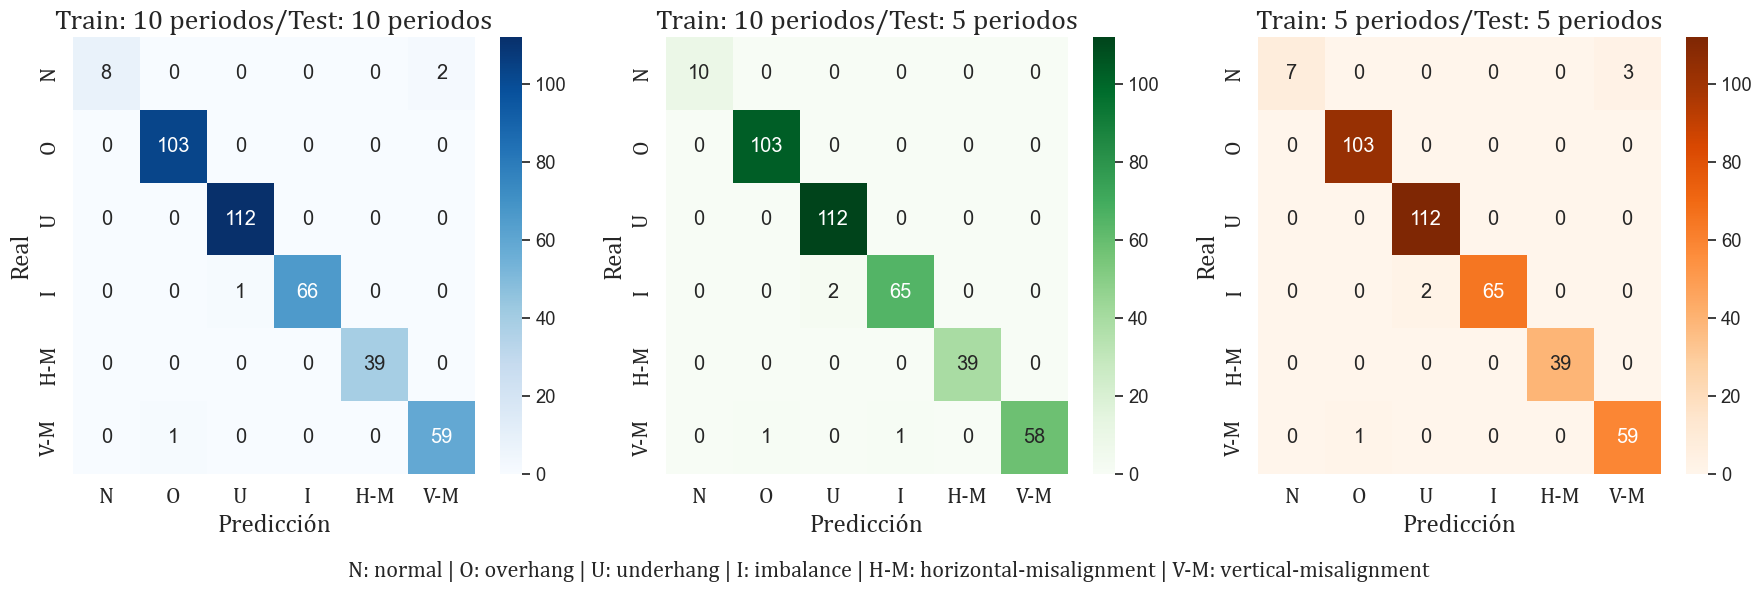

In [34]:
abbreviations = ["N", "O", "U", "I", "H-M", "V-M"]
class_values = list(label_map.values())
cm1 = confusion_matrix(y1_test, y2_pred2, labels=class_values)
cm2 = confusion_matrix(y2_test, y3_pred2, labels=class_values)
cm3 = confusion_matrix(y2_test, y3_pred3, labels=class_values)

classes = np.unique(np.concatenate([y1_test, y2_test]))

sns.set(font_scale=1.2, style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.set(font_scale=1.2)

def plot_cm(ax, cm, title, cmap="Blues"):
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=abbreviations, yticklabels=abbreviations, ax=ax)
    ax.set_title(title, fontsize=20, fontfamily="Cambria")
    ax.set_xlabel("Predicción", fontsize=18, fontfamily="Cambria")
    ax.set_ylabel("Real", fontsize=18, fontfamily="Cambria")
    # Cambiar fuente de ticks
    ax.tick_params(axis='both', labelsize=16)
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontfamily("Cambria")

plot_cm(axs[0], cm1, "Train: 10 periodos/Test: 10 periodos", cmap="Blues")
plot_cm(axs[1], cm2, "Train: 10 periodos/Test: 5 periodos", cmap="Greens")
plot_cm(axs[2], cm3, "Train: 5 periodos/Test: 5 periodos", cmap="Oranges")
legend_text = " | ".join([f"{abbr}: {name}" for abbr, name in zip(abbreviations, label_map.keys())])
plt.gcf().text(0.5, 0.01, legend_text, fontsize=16, fontfamily="Cambria",
               ha='center', va='bottom')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("confusion_matrices.png", dpi=300)
plt.show()

In [68]:
df1 = pd.read_csv("features_bearing_fault_detection2.csv")
df2 = pd.read_csv("features_bearing_fault_detection_short_10t.csv")
df3 = pd.read_csv("features_bearing_fault_detection_short_5t.csv")

df1.drop(columns=['fault', 'file', 'fault2'], inplace=True)
df2.drop(columns=['fault', 'file', 'fault2'], inplace=True)
df3.drop(columns=['fault', 'file', 'fault2'], inplace=True)

output_dir = "features_comparison"
os.makedirs(output_dir, exist_ok=True)

common_cols = sorted(set(df1.columns).intersection(df2.columns))
print(f"Comparando {len(common_cols)} features")

for col in tqdm(common_cols, desc="Generando gráficos"):
    plt.figure(figsize=(10, 5))

    plt.plot(df1[col].values, label="Señal entera", alpha=0.7)
    plt.plot(df2[col].values, label="10 periodos", alpha=0.7)
    plt.plot(df3[col].values, label="5 periodos", alpha=0.7)

    plt.title(col, fontsize=16, fontfamily="Cambria")
    plt.xlabel("Índice de la muestra", fontsize=14, fontfamily="Cambria")
    plt.ylabel("Kurtosis", fontsize=14, fontfamily="Cambria")
    plt.legend(fontsize=12, prop={"family": "Cambria"})
    plt.grid(True)

    plt.xticks(fontsize=12, fontfamily="Cambria")
    plt.yticks(fontsize=12, fontfamily="Cambria")

    out_path = os.path.join(output_dir, f"{col}.png")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()


Comparando 126 features


Generando gráficos: 100%|██████████| 126/126 [02:19<00:00,  1.10s/it]
